# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
#pd.set_option('display.max_columns', 100)
pd.options.display.max_columns = 100

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

In [2]:
df = pd.read_csv('kc_house_data_train.csv', index_col=0)

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17290 non-null  int64  
 1   date           17290 non-null  object 
 2   price          17290 non-null  float64
 3   bedrooms       17290 non-null  int64  
 4   bathrooms      17290 non-null  float64
 5   sqft_living    17290 non-null  int64  
 6   sqft_lot       17290 non-null  int64  
 7   floors         17290 non-null  float64
 8   waterfront     17290 non-null  int64  
 9   view           17290 non-null  int64  
 10  condition      17290 non-null  int64  
 11  grade          17290 non-null  int64  
 12  sqft_above     17290 non-null  int64  
 13  sqft_basement  17290 non-null  int64  
 14  yr_built       17290 non-null  int64  
 15  yr_renovated   17290 non-null  int64  
 16  zipcode        17290 non-null  int64  
 17  lat            17290 non-null  float64
 18  long  

## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

In [146]:
dfc = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
dfc['pairs'] = list(zip(dfc.level_0, dfc.level_1))
dfc.set_index(['pairs'], inplace=True)
dfc.drop(columns=['level_1', 'level_0'], inplace=True)
dfc.columns = ['correlation']
dfc.drop_duplicates(inplace=True)
dfc[(dfc.correlation>.75)&(dfc.correlation<1)]

,correlation
pairs,
"(rating, grade)",0.996747
"(yr_built, renovate)",0.977603
"(yr_built, renovate_scaled)",0.977603
"(sqft_living, sqft_above)",0.876696
"(condition_3, condition_4)",0.810849
"(month, year)",0.781982
"(grade, sqft_living)",0.762929
"(grade, sqft_above)",0.758247
"(sqft_living, rating)",0.755538


In [6]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [7]:
col = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade',
'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated','sqft_living15', 'sqft_lot15']

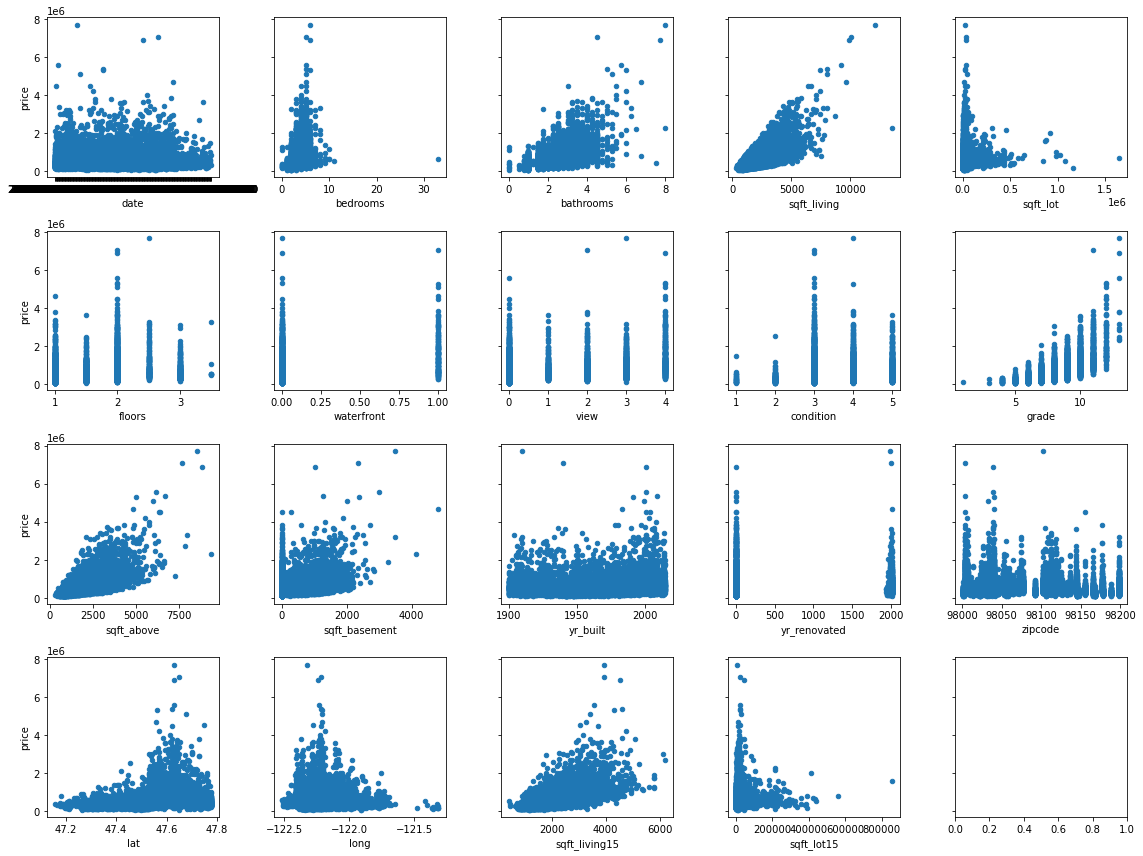

In [43]:
fig, axes = plt.subplots(3,5, sharey=True, figsize=(16,12))
for ax, c in zip(axes.flat, col):
    df.plot.scatter(x=c, y='price', ax=ax)
plt.tight_layout()

## Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

In [45]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bath,bed_2,bed_3,bed_4,bed_5,bed_6,year,month,s_summer,s_winter,renovate,rating,bath-rating,bath-rating_scaled,renovate_scaled
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,0.001932,0,0,1,0,0,2014,10,0,0,28.0,8,0.008696,0.226991,-0.504852
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,0.001724,0,0,0,1,0,2014,8,0,0,37.0,8,0.008276,0.052750,-0.188178
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,0.001061,0,0,1,0,0,2014,8,0,0,17.0,11,0.007294,-0.354610,-0.891897
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,0.000658,0,1,0,0,0,2015,3,0,0,25.0,11,0.008443,0.122116,-0.610409
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,0.001176,0,1,0,0,0,2014,7,1,0,10.0,9,0.008824,0.280069,-1.138198


## Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [9]:
condlist = [df.bedrooms<2, df.bedrooms>5]
choicelist = [1, 6]
df['bed'] = np.select(condlist, choicelist, df.bedrooms)

In [10]:
df = pd.get_dummies(df, columns=['bed'], drop_first=True)

In [66]:
df = pd.get_dummies(df, columns=['condition'], drop_first=True)

### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

In [11]:
df['year'] = pd.to_datetime(df.date).dt.year
df['month'] = pd.to_datetime(df.date).dt.month

In [12]:
condlist = [df.month.isin([4,5,6,7]), df.month.isin([1,2,12])]
choicelist = ['summer','winter']
df['season'] = np.select(condlist, choicelist, 'springfall')

In [13]:
df = pd.get_dummies(df, columns=['season'], prefix='s', drop_first=True)

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

In [14]:
r = 0.5
df['renovate'] = np.where(df.yr_renovated==0, df.year-df.yr_built, df.year-df.yr_renovated*r-df.yr_built*(1-r))

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

In [69]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'bath', 'bed_2', 'bed_3', 'bed_4',
       'bed_5', 'bed_6', 'year', 'month', 's_summer', 's_winter', 'renovate',
       'rating', 'bath-rating', 'bath-rating_scaled', 'renovate_scaled',
       'condition_2', 'condition_3', 'condition_4', 'condition_5'],
      dtype='object')

In [70]:
target = df.price
df_features = df[['sqft_living',
       'sqft_living15',  'bath', 'bed_2', 'bed_3', 'bed_4',
       'bed_5', 'bed_6', 's_summer', 's_winter', 'renovate',
       'rating', 'bath-rating', 'bath-rating_scaled', 'renovate_scaled',
       'condition_2', 'condition_3', 'condition_4', 'condition_5']]

In [16]:
lm = LinearRegression()
lm = lm.fit(df_features, target)

lm.intercept_,lm.coef_,lm.score(df_features, target)

(-202337.28605310328,
 array([ 309.78954841, 2320.31207856]),
 0.5225839462197183)

In [17]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(df_features)
poly_columns = poly.get_feature_names(df_features.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)

lm_2 = LinearRegression()
lm_2 = lm_2.fit(df_poly, target)
lm_2.intercept_,lm_2.coef_,lm_2.score(df_poly, target)

(230540.158778909,
 array([ 4.21439513e+01, -3.81852475e+03,  3.86656045e-02,  1.23745576e+00,
         3.30008929e+01]),
 0.5664685583078954)

In [18]:
poly_3 = PolynomialFeatures(degree=3, include_bias=False)
poly3_data = poly_3.fit_transform(df_features)
poly3_columns = poly_3.get_feature_names(df_features.columns)
df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)

lm_3 = LinearRegression()
lm_3 = lm_3.fit(df_poly3, target)
lm_3.score(df_poly3, target)

0.5789098339620334

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [22]:
condlist = [df.grade<6, df.grade>10]
choicelist = [5, 11]
df['rating'] = np.select(condlist, choicelist, df.grade)

In [24]:
df['bath-rating'] = df.bathrooms*df.rating/df.sqft_living

## Step 5: Train-Test Split

If you plan on doing any scaling of your data, make sure it is done at the appropriate time. 

### 5.1) Perform a train-test split of the data.

In [71]:
x_train, x_test, y_train, y_test = train_test_split(df_features, target, random_state=34, test_size=0.2)

lm = linear_model.LinearRegression()
lm = lm.fit(x_train, y_train)

lm.intercept_,lm.coef_,lm.score(df_features, target)

(-1127063.297519167,
 array([ 3.43619849e+02,  3.70095460e+01,  1.52543437e+08, -1.48370981e+05,
        -3.05181936e+05, -4.28783415e+05, -4.85580473e+05, -5.86818353e+05,
         2.59688859e+03, -1.35592697e+04,  3.70593048e+03,  1.02868012e+05,
         1.12417439e+02,  4.66607649e+04,  1.30396518e+02, -4.09625077e+04,
        -5.63679836e+03,  6.59657840e+03,  4.56185447e+04]),
 0.6311506435303746)

### 5.2) Fit your scaler to training the data.

In [141]:
# scaler = StandardScaler()
# subset = ['bath-rating', 'renovate']
# subset_scaled = []
# for var in subset:
#     new_col = var +"_scaled"
#     df[new_col] = scaler.fit_transform(df[[var]])
#     subset_scaled.append(new_col)

scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

### 5.3) Transform the testing set with the scaler.

In [142]:
x_train = pd.DataFrame(data=scaler.transform(x_train), columns=df_features.columns)
x_test = pd.DataFrame(data=scaler.transform(x_test), columns=df_features.columns)

### 5.4) Fit the model to the training data.

In [74]:
lm = LinearRegression()
lm = lm.fit(x_train, y_train)

y_train_pred = lm.predict(x_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 224733.4852038488


### 5.5) Use the model to predict on the training set and the test set.

In [33]:
y_test_pred = lm.predict(x_test)

### 5.6) Evaluate the training and test predictions using RMSE.

In [34]:
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 265259.7785967678
Training:  256078 vs. Testing:  265259


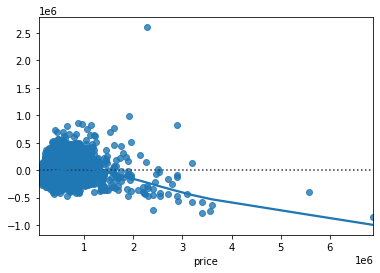

In [49]:
sns.residplot(y_test, y_test_pred,lowess=True)

### 5.7) Determine if your model is overfit.

In [75]:
vif = pd.DataFrame()
vif['features'] = df_features.columns
vif['VIF'] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]
vif.sort_values('VIF', ascending=False)

/Users/mbcn345/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,features,VIF
12,bath-rating,inf
14,renovate_scaled,inf
13,bath-rating_scaled,inf
10,renovate,inf
16,condition_3,166.065000
17,condition_4,140.910334
18,condition_5,53.827348
4,bed_3,30.387083
5,bed_4,29.973982
3,bed_2,12.977585


## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [97]:
selector = SelectKBest(f_regression, k=10)

selector.fit(x_train, y_train)

selected_columns = x_train.columns[selector.get_support()]
removed_columns = x_train.columns[~selector.get_support()]

SelectKBest(score_func=<function f_regression at 0x7fb5704358b0>)

In [81]:
selected_columns

Index(['sqft_living', 'sqft_living15', 'bath', 'bed_2', 'bed_3', 'bed_4',
       'bed_5', 'bed_6', 'renovate', 'rating'],
      dtype='object')

In [82]:
#selected_columns
removed_columns

Index(['s_summer', 's_winter', 'bath-rating', 'bath-rating_scaled',
       'renovate_scaled', 'condition_2', 'condition_3', 'condition_4',
       'condition_5'],
      dtype='object')

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [85]:
lm_kbest = LinearRegression()
lm_kbest.fit(x_train[selected_columns], y_train)
y_train_kbest = lm_kbest.predict(x_train[selected_columns])
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
print('Training Root Mean Squared Error:' , trainK_rmse)
y_kbest = lm_kbest.predict(x_test[selected_columns])
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 228239.07036150884
Testing Root Mean Squared Error: 237800.0171994938


In [140]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bath,bed_2,bed_3,bed_4,bed_5,bed_6,year,month,s_summer,s_winter,renovate,rating,bath-rating,bath-rating_scaled,renovate_scaled,condition_2,condition_3,condition_4,condition_5
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,0.001932,0,0,1,0,0,2014,10,0,0,28.0,8,0.008696,0.226991,-0.504852,0,0,1,0
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,0.001724,0,0,0,1,0,2014,8,0,0,37.0,8,0.008276,0.052750,-0.188178,0,0,0,1
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,0.001061,0,0,1,0,0,2014,8,0,0,17.0,11,0.007294,-0.354610,-0.891897,0,1,0,0
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,0.000658,0,1,0,0,0,2015,3,0,0,25.0,11,0.008443,0.122116,-0.610409,0,1,0,0
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,0.001176,0,1,0,0,0,2014,7,1,0,10.0,9,0.008824,0.280069,-1.138198,0,1,0,0


## Step 7: Evaluate your different models in order to determine the best model overall.

In [137]:
ols = linear_model.LinearRegression()

selector = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error', n_jobs=1)
selector.fit(x_train, y_train)

RFECV(cv=10, estimator=Lasso(alpha=500), n_jobs=1,
      scoring='neg_mean_squared_error')

In [138]:
selected_rfe = x_train.columns[selector.support_]
removed_rfe = x_train.columns[~selector.support_]
removed_rfe

Index(['s_summer', 'bath-rating_scaled', 'condition_4'], dtype='object')

In [139]:
selected_rfe

Index(['sqft_living', 'sqft_living15', 'bath', 'bed_2', 'bed_3', 'bed_4',
       'bed_5', 'bed_6', 's_winter', 'renovate', 'rating', 'bath-rating',
       'renovate_scaled', 'condition_2', 'condition_3', 'condition_5'],
      dtype='object')

In [96]:
lm_rfe = LinearRegression()
lm_rfe = lm_rfe.fit(x_train[selected_rfe], y_train)
y_rfe = lm_rfe.predict(x_train[selected_rfe])

trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))

print('Training Root Mean Squared Error:' , trainRFE_rmse)
y_pred_rfe = lm_rfe.predict(x_test[selected_rfe])
testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
print('Testing Root Mean Squared Error:' , testRFE_rmse)

Training Root Mean Squared Error: 224736.5980231001
Testing Root Mean Squared Error: 234515.92671640526


In [143]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=500, normalize=False)

lasso.fit(x_train,y_train)

y_train_pred = lasso.predict(x_train)
y_pred = lasso.predict(x_test)

train_rmse_lasso = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_lasso))
print('Testing Error: '+ str(test_rmse_lasso))

Training Error: 141867.22284868002
Testing Error: 235201.97007696063


In [144]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=500, normalize=False)

ridge.fit(x_train,y_train)

y_train_pred = ridge.predict(x_train)
y_pred = ridge.predict(x_test)

train_rmse_ridge = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_ridge = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_ridge))
print('Testing Error: '+ str(test_rmse_ridge))

Training Error: 141534.11200252778
Testing Error: 238581.55914786988


## Step 8:  Refit your best model to the entire dataset.

In [ ]:
final_scaler = StandardScaler()


#fit and transform the training data
df_final_scaled = pd.DataFrame(data=final_scaler.fit_transform(df_poly[selected_rfe]), columns=selected_rfe)

lm_final = LinearRegression()

lm_final = lm_rfe.fit(df_final_scaled, df['price'])

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [ ]:
import pickle


pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

pickle_out = open('scaler.pickle", "wb"')
pickle.dump(scaler, pickle_out)
pickle_out.close